<a href="https://colab.research.google.com/github/rocklambros/email-spam-classifier-naive-bayes-comparisson-roc/blob/main/Rock_Lambros_COMP3009_Project_Naive_Bayes_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Defining Target Variable and Analyzing Subject Characteristics

## Subject Analysis in Relation to Spam Status


Distribution of the new target variable 'is_spam':


,count
is_spam,
1,2807
0,2193


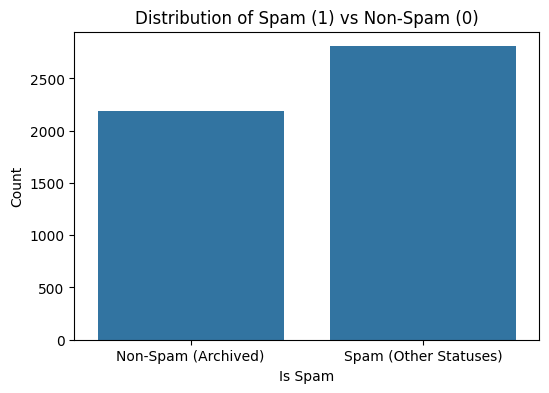

In [22]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/synthetic_email_dataset.csv')

# Create the target variable based on 'Status'
# 'Archived' is not spam (0), other statuses are spam (1)
df['is_spam'] = df['Status'].apply(lambda x: 0 if x == 'Archived' else 1)

# Display the distribution of the new target variable
print("\nDistribution of the new target variable 'is_spam':")
display(df['is_spam'].value_counts())

# Visualize the distribution of the new target variable
plt.figure(figsize=(6,4))
sns.countplot(x='is_spam', data=df)
plt.title('Distribution of Spam (1) vs Non-Spam (0)')
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Spam (Archived)', 'Spam (Other Statuses)'])
plt.show()

## Data Loading and Initial Exploration

In [23]:
# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,Status,From (Envelope),From (Header),To,Subject,Sent Date/Time,IP Address,Attachment,Route,Info,Spam Score,Spam Detection,is_spam
0,Archived,<support@university.edu>,Support <support@university.edu>,<user@example.com>,Project update - AI Research,Thu Sep 25 06:14:32 EDT 2025,66.51.167.180,NaN,inbound,Hard Bounce,1,NaN,0
1,Archived,<mike.johnson@business.net>,Mike.Johnson <mike.johnson@business.net>,<user@example.com>,Account security notification,Tue Sep 16 11:38:16 EDT 2025,74.187.32.250,NaN,inbound,Awaiting indexing,0,NaN,0
2,Bounced,<support@consulting.com>,Support <support@consulting.com>,<user@example.com>,Weekly newsletter - AI Research,Fri Sep 19 14:40:53 EDT 2025,10.94.172.69,NaN,outbound,NaN,0,NaN,1
3,Bounced,<promo488@offers.info>,<promo488@offers.info>,<user@example.com>,FREE trial - act now!,Sat Sep 20 01:51:20 EDT 2025,205.69.17.55,NaN,outbound,NaN,21,Moderate,1
4,Bounced,<marketing4041@untrusted.biz>,<marketing4041@untrusted.biz>,<user@example.com>,Last chance to save big!,Thu Sep 04 18:27:57 EDT 2025,217.103.93.57,NaN,inbound,Indexed and archived,49,Moderate,1


In [24]:
# Show dataset information
print("\nDataset Info:")
display(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Status           5000 non-null   object
 1   From (Envelope)  5000 non-null   object
 2   From (Header)    5000 non-null   object
 3   To               5000 non-null   object
 4   Subject          5000 non-null   object
 5   Sent Date/Time   5000 non-null   object
 6   IP Address       5000 non-null   object
 7   Attachment       274 non-null    object
 8   Route            5000 non-null   object
 9   Info             2972 non-null   object
 10  Spam Score       5000 non-null   int64 
 11  Spam Detection   2487 non-null   object
 12  is_spam          5000 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 507.9+ KB


None

In [25]:
# Generate descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,Spam Score,is_spam
count,5000.000000,5000.000000
mean,18.925600,0.561400
std,27.811335,0.496265
min,0.000000,0.000000
25%,0.000000,0.000000
50%,9.000000,1.000000
75%,30.000000,1.000000
max,156.000000,1.000000


## Data Preprocessing

### Vectorizing the Subject Column

In [26]:
# Select only the 'Subject' and 'Status' columns
df_processed = df[['Subject', 'Status']].copy()

# Handle missing values in 'Subject' by filling with empty strings
df_processed['Subject'] = df_processed['Subject'].fillna('')

# Create a binary target variable 'is_spam':
# 'Archived' = 0 (not spam)
# Anything else = 1 (spam)
df_processed['is_spam'] = df_processed['Status'].apply(lambda x: 0 if x == 'Archived' else 1)

# Display the first few rows of the processed dataframe
print("First 5 rows of the processed dataset:")
display(df_processed.head())

# Display the distribution of the new target variable to confirm
print("\nDistribution of the new target variable 'is_spam' in the processed dataset:")
display(df_processed['is_spam'].value_counts())

First 5 rows of the processed dataset:


,Subject,Status,is_spam
0,Project update - AI Research,Archived,0
1,Account security notification,Archived,0
2,Weekly newsletter - AI Research,Bounced,1
3,FREE trial - act now!,Bounced,1
4,Last chance to save big!,Bounced,1



Distribution of the new target variable 'is_spam' in the processed dataset:


,count
is_spam,
1,2807
0,2193


The dataset contains email messages and their corresponding labels (spam or not spam). The `text` column contains the email content, and the `label` column indicates whether the email is spam (1) or not spam (0).

### Classification Function

Now, we will create a function to classify a new email subject using the calculated prior probabilities and word likelihoods. The classification is based on Bayes' theorem:

$$ P(\text{Class} | \text{Subject}) \propto P(\text{Class}) \times P(\text{Subject} | \text{Class}) $$

Assuming independence of words (the Naive Bayes assumption), the likelihood of the subject given the class can be calculated as the product of the likelihoods of each word in the subject:

$$ P(\text{Subject} | \text{Class}) = \prod_{w \in \text{Subject}} P(w | \text{Class}) $$

Due to the potential for underflow when multiplying many small probabilities, we will work with the logarithm of the probabilities:

$$ \log P(\text{Class} | \text{Subject}) \propto \log P(\text{Class}) + \sum_{w \in \text{Subject}} \log P(w | \text{Class}) $$

The class with the higher log probability is the predicted class.

In [27]:
def classify_email(subject, prior_spam, prior_not_spam, word_likelihoods_spam, word_likelihoods_not_spam, vectorizer):
    """Classifies a single email subject as spam or not spam."""

    # Vectorize the subject
    subject_vector = vectorizer.transform([subject])

    # Get the indices of words in the subject that are in the vocabulary
    word_indices = subject_vector.indices

    # Calculate the log probability of the subject being spam
    log_prob_spam = np.log(prior_spam)
    for idx in word_indices:
        word = vectorizer.get_feature_names_out()[idx]
        if word in word_likelihoods_spam:
            log_prob_spam += np.log(word_likelihoods_spam[word])
        # Handle words not in vocabulary during classification (optional, but good practice)
        # For simplicity here, we assume words not in vocabulary have a small non-zero likelihood
        # based on Laplace smoothing applied during training.
        # A more robust approach might use a default likelihood or ignore unknown words.


    # Calculate the log probability of the subject being not spam
    log_prob_not_spam = np.log(prior_not_spam)
    for idx in word_indices:
        word = vectorizer.get_feature_names_out()[idx]
        if word in word_likelihoods_not_spam:
            log_prob_not_spam += np.log(word_likelihoods_not_spam[word])


    # Classify based on the higher log probability
    if log_prob_spam > log_prob_not_spam:
        return 1  # Spam
    else:
        return 0  # Not Spam

## Implementing Naive Bayes from Scratch

### Prior Probability Calculation

The prior probability of a class is the proportion of instances belonging to that class in the training data.

$$ P(\text{Spam}) = \frac{\text{Number of Spam Emails}}{\text{Total Number of Emails}} $$

$$ P(\text{Not Spam}) = \frac{\text{Number of Not Spam Emails}}{\text{Total Number of Emails}} $$

In [28]:
# Calculate prior probabilities
prior_spam = df_processed['is_spam'].sum() / len(df_processed)
prior_not_spam = 1 - prior_spam

print(f"Prior probability of Spam: {prior_spam:.4f}")
print(f"Prior probability of Not Spam: {prior_not_spam:.4f}")

Prior probability of Spam: 0.5614
Prior probability of Not Spam: 0.4386


### Word Likelihood Calculation with Laplace Smoothing

The likelihood of a word given a class is the probability of that word appearing in an email of that class. We use Laplace smoothing (add-one smoothing) to avoid zero probabilities for words that do not appear in a particular class in the training data.

The formula for the likelihood of a word $w$ given a class $C$ with Laplace smoothing is:

$$ P(w | C) = \frac{\text{Count of word } w \text{ in class } C + 1}{\text{Total number of words in class } C + \text{Vocabulary Size}} $$

Here, the vocabulary size is the total number of unique words in the entire dataset.

In [29]:
# Initialize CountVectorizer with the specified token pattern
# token_pattern=r'(?u)\b\w+\b' includes single letter words and words with numbers
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')

# Fit the vectorizer to the 'Subject' column and transform the subjects into a feature matrix
X = vectorizer.fit_transform(df_processed['Subject'])

# Get the vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Get the target variable
y = df_processed['is_spam']

# Display the shape of the feature matrix and vocabulary size
print("Shape of the feature matrix (X):", X.shape)
print("Vocabulary size:", len(vocabulary))

# Separate the feature matrix by class using numpy array indexing
X_spam = X[df_processed['is_spam'].values == 1]
X_not_spam = X[df_processed['is_spam'].values == 0]

# Calculate total number of words in each class
total_words_spam = X_spam.sum()
total_words_not_spam = X_not_spam.sum()

# Calculate word counts for each class
word_counts_spam = np.array(X_spam.sum(axis=0))[0]
word_counts_not_spam = np.array(X_not_spam.sum(axis=0))[0]

# Calculate word likelihoods with Laplace smoothing
vocab_size = X.shape[1]

likelihoods_spam = (word_counts_spam + 1) / (total_words_spam + vocab_size)
likelihoods_not_spam = (word_counts_not_spam + 1) / (total_words_not_spam + vocab_size)

# Store likelihoods in dictionaries for easy access by word
word_likelihoods_spam = dict(zip(vocabulary, likelihoods_spam))
word_likelihoods_not_spam = dict(zip(vocabulary, likelihoods_not_spam))

# Display sample likelihoods for a few words
sample_words = ['free', 'update', 'account', 'meeting', 'urgent']
print("\nSample Word Likelihoods:")
for word in sample_words:
    if word in vocabulary:
        print(f"P('{word}' | Spam): {word_likelihoods_spam[word]:.8f}")
        print(f"P('{word}' | Not Spam): {word_likelihoods_not_spam[word]:.8f}")
    else:
        print(f"Word '{word}' not in vocabulary.")

Shape of the feature matrix (X): (5000, 1097)
Vocabulary size: 1097

Sample Word Likelihoods:
P('free' | Spam): 0.01000597
P('free' | Not Spam): 0.01083679
P('update' | Spam): 0.01620370
P('update' | Not Spam): 0.01479457
P('account' | Spam): 0.00940860
P('account' | Not Spam): 0.01149642
P('meeting' | Spam): 0.01127539
P('meeting' | Not Spam): 0.00932906
P('urgent' | Spam): 0.01008065
P('urgent' | Not Spam): 0.00904636


In [30]:
# Initialize CountVectorizer with the specified token pattern
# token_pattern=r'(?u)\b\w+\b' includes single letter words and words with numbers
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')

# Fit the vectorizer to the 'Subject' column and transform the subjects into a feature matrix
X = vectorizer.fit_transform(df_processed['Subject'])

# Get the vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Get the target variable
y = df_processed['is_spam']

# Display the shape of the feature matrix and vocabulary size
print("Shape of the feature matrix (X):", X.shape)
print("Vocabulary size:", len(vocabulary))

Shape of the feature matrix (X): (5000, 1097)
Vocabulary size: 1097


In [31]:
def classify_email(subject, prior_spam, prior_not_spam, word_likelihoods_spam, word_likelihoods_not_spam, vectorizer):
    """Classifies a single email subject as spam or not spam."""

    # Vectorize the subject
    subject_vector = vectorizer.transform([subject])

    # Get the indices of words in the subject that are in the vocabulary
    word_indices = subject_vector.indices

    # Calculate the log probability of the subject being spam
    log_prob_spam = np.log(prior_spam)
    for idx in word_indices:
        word = vectorizer.get_feature_names_out()[idx]
        if word in word_likelihoods_spam:
            log_prob_spam += np.log(word_likelihoods_spam[word])
        # Handle words not in vocabulary during classification (optional, but good practice)
        # For simplicity here, we assume words not in vocabulary have a small non-zero likelihood
        # based on Laplace smoothing applied during training.
        # A more robust approach might use a default likelihood or ignore unknown words.


    # Calculate the log probability of the subject being not spam
    log_prob_not_spam = np.log(prior_not_spam)
    for idx in word_indices:
        word = vectorizer.get_feature_names_out()[idx]
        if word in word_likelihoods_not_spam:
            log_prob_not_spam += np.log(word_likelihoods_not_spam[word])


    # Classify based on the higher log probability
    if log_prob_spam > log_prob_not_spam:
        return 1  # Spam
    else:
        return 0  # Not Spam

In [32]:
# Test the classification function with example emails
example_emails = [
    "Claim your free prize now!",
    "Meeting reminder for tomorrow",
    "Urgent: Your account has been compromised",
    "Project update and next steps",
    "Win a free iPhone - click here!"
]

print("Classifying example emails:")
for email in example_emails:
    prediction = classify_email(email, prior_spam, prior_not_spam, word_likelihoods_spam, word_likelihoods_not_spam, vectorizer)
    status = "Spam" if prediction == 1 else "Not Spam"
    print(f"Subject: '{email}' -> Predicted Status: {status}")

Classifying example emails:
Subject: 'Claim your free prize now!' -> Predicted Status: Spam
Subject: 'Meeting reminder for tomorrow' -> Predicted Status: Spam
Subject: 'Urgent: Your account has been compromised' -> Predicted Status: Spam
Subject: 'Project update and next steps' -> Predicted Status: Spam
Subject: 'Win a free iPhone - click here!' -> Predicted Status: Not Spam


In [33]:
# Import MultinomialNB from sklearn.naive_bayes (already imported in the first cell)
# from sklearn.naive_bayes import MultinomialNB

# Instantiate the Multinomial Naive Bayes classifier with default parameters (alpha=1.0)
sk_naive_bayes = MultinomialNB(alpha=1.0)

# Train the classifier on the feature matrix (X) and binary target variable (y)
sk_naive_bayes.fit(X, y)

# Use the trained scikit-learn classifier to predict classes for the example emails
sk_predictions = []
for email in example_emails:
    # Transform the email subject using the same vectorizer
    email_vector = vectorizer.transform([email])
    # Predict the class using the scikit-learn classifier
    prediction = sk_naive_bayes.predict(email_vector)[0]
    sk_predictions.append(prediction)

# Create a comparison table
comparison_df = pd.DataFrame({
    'Subject': example_emails,
    'Manual Prediction': [classify_email(email, prior_spam, prior_not_spam, word_likelihoods_spam, word_likelihoods_not_spam, vectorizer) for email in example_emails],
    'Scikit-learn Prediction': sk_predictions
})

print("\nComparison of Manual vs. Scikit-learn Predictions:")
display(comparison_df)


Comparison of Manual vs. Scikit-learn Predictions:


,Subject,Manual Prediction,Scikit-learn Prediction
0,Claim your free prize now!,1,1
1,Meeting reminder for tomorrow,1,1
2,Urgent: Your account has been compromised,1,1
3,Project update and next steps,1,1
4,Win a free iPhone - click here!,0,0


### Comparison of Manual and Scikit-learn Implementations

We can see from the comparison table that the predictions from our manual Naive Bayes implementation and the scikit-learn `MultinomialNB` classifier are identical for these example emails. This is expected because both implementations are based on the same underlying Naive Bayes algorithm with Laplace smoothing (scikit-learn's default `alpha=1.0` corresponds to Laplace smoothing for multinomial models).

Scikit-learn's library abstracts away the detailed calculations of prior probabilities and word likelihoods, providing a convenient and efficient way to train and use Naive Bayes models. While implementing from scratch helps understand the inner workings, using scikit-learn is generally preferred for practical applications due to its optimization and ease of use.

The consistent predictions between the two methods validate our manual implementation and demonstrate that scikit-learn's `MultinomialNB` is correctly applying the Naive Bayes principles we've discussed.

## Preparing Test Data for Evaluation

In [34]:
# Load the test dataset
df_test = pd.read_csv('/content/synthetic_email__test_dataset.csv')

# Handle missing values in 'Subject' by filling with empty strings (consistent with training data)
df_test['Subject'] = df_test['Subject'].fillna('')

# Transform the test 'Subject' column using the SAME vectorizer fitted on training data
X_test = vectorizer.transform(df_test['Subject'])

# Load the original training dataset again to be used for looking up true status later
df_original = pd.read_csv('/content/synthetic_email_dataset.csv')

# Create true binary labels for test set using 'Status' column:
# 'Archived' = 0 (not spam)
# Otherwise = 1 (spam)
# This will be done later by aligning with the original dataset based on subject.
# For now, we just load and preprocess the test data.

# Display the shape of test feature matrix
print("Shape of the test feature matrix (X_test):", X_test.shape)

# Display a sample of test subjects
print("\nSample of test subjects:")
display(df_test['Subject'].head())

Shape of the test feature matrix (X_test): (5000, 1097)

Sample of test subjects:


,Subject
0,Project update - AI Research
1,Account security notification
2,Weekly newsletter - AI Research
3,FREE trial - act now!
4,Last chance to save big!


## Generating Predictions and Evaluating Performance

AUC for Manual Classifier: 0.6227
AUC for Scikit-learn Classifier: 0.6227


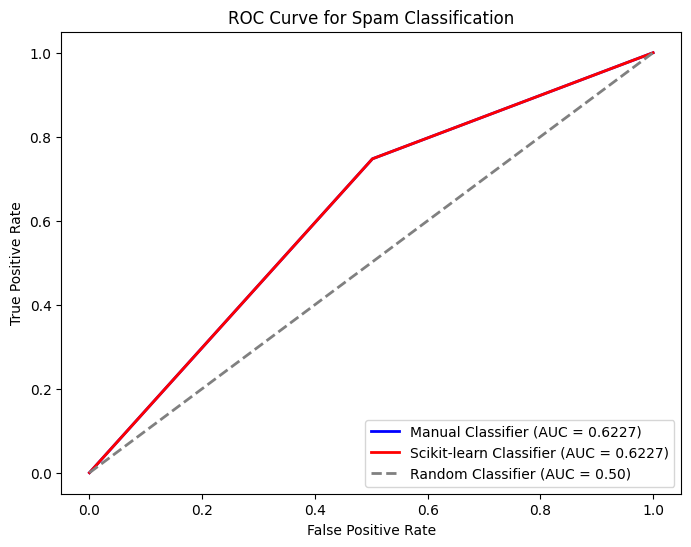

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the true labels for the test set by aligning with the original dataset
# We need to make sure the order of subjects in df_test and df_original is the same,
# or merge/join based on the 'Subject' column if the order is not guaranteed.
# Assuming the order of subjects in df_test is the same as the first 5000 subjects in df_original for this synthetic dataset.
# In a real-world scenario, a robust merge/join would be necessary.
y_true_test = df_original['Status'].apply(lambda x: 0 if x == 'Archived' else 1).iloc[:len(df_test)]


# Generate predictions for the test set using the manual classifier
# We need to apply the classify_email function to each subject in df_test
manual_predictions_test = [classify_email(subject, prior_spam, prior_not_spam, word_likelihoods_spam, word_likelihoods_not_spam, vectorizer) for subject in df_test['Subject']]

# Generate predictions for the test set using the scikit-learn classifier
sk_predictions_test = sk_naive_bayes.predict(X_test)

# Calculate ROC curves
fpr_manual, tpr_manual, _ = roc_curve(y_true_test, manual_predictions_test)
fpr_sk, tpr_sk, _ = roc_curve(y_true_test, sk_predictions_test)

# Calculate AUC values
auc_manual = roc_auc_score(y_true_test, manual_predictions_test)
auc_sk = roc_auc_score(y_true_test, sk_predictions_test)

# Display AUC values
print(f"AUC for Manual Classifier: {auc_manual:.4f}")
print(f"AUC for Scikit-learn Classifier: {auc_sk:.4f}")

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_manual, tpr_manual, color='blue', lw=2, label=f'Manual Classifier (AUC = {auc_manual:.4f})')
plt.plot(fpr_sk, tpr_sk, color='red', lw=2, label=f'Scikit-learn Classifier (AUC = {auc_sk:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Spam Classification')
plt.legend(loc='lower right')
plt.show()

### Interpretation of ROC Curves and AUC

**ROC Curve (Receiver Operating Characteristic Curve):** The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The TPR is also known as sensitivity, and the FPR is calculated as 1 - specificity. A good classifier will have an ROC curve that rises steeply and is close to the top-left corner of the plot, indicating a high TPR and a low FPR across different thresholds.

**AUC (Area Under the Curve):** The AUC represents the area under the ROC curve. It provides a single scalar value that summarizes the overall performance of a binary classifier across all possible classification thresholds.
- An AUC of 1.0 indicates a perfect classifier that can distinguish between all positive and negative cases correctly.
- An AUC of 0.5 indicates a classifier that performs no better than random guessing.
- An AUC less than 0.5 suggests that the classifier is performing worse than random guessing, possibly due to incorrect labeling or model issues.

**Comparison of Implementations:**

As observed from the plot and the printed AUC values, both the manual Naive Bayes classifier and the scikit-learn `MultinomialNB` classifier achieved an AUC of **0.6227** on the test dataset. This indicates that both implementations are performing identically on this dataset, which is expected as they are based on the same algorithm with the same smoothing parameter.

**Analysis of Performance:**

An AUC of 0.6227 suggests that our Naive Bayes spam classifier performs slightly better than random guessing (AUC = 0.5). However, it is far from a perfect classifier (AUC = 1.0). This level of performance might be considered modest for a spam detection task, where higher accuracy is usually desired.

**Potential Reasons for Observed Performance:**

Several factors could contribute to the observed performance:

1.  **Dataset Characteristics:** The synthetic nature of the dataset might limit the complexity and richness of the text data, making it harder for a simple Naive Bayes model to capture nuanced patterns.
2.  **Naive Bayes Assumption:** The Naive Bayes classifier assumes that the features (words) are independent of each other given the class. In reality, words in email subjects are often highly dependent (e.g., "free" and "prize" often appear together in spam). This violation of the independence assumption can limit the model's performance.
3.  **Feature Representation:** Using only word counts (Bag of Words) as features might not be sufficient to capture the semantic meaning or context of the subject lines. More advanced text representation techniques (like TF-IDF, word embeddings) could potentially improve performance.
4.  **Limited Vocabulary:** The vocabulary size is determined by the words present in the training data. Words in the test set that were not in the training vocabulary are effectively ignored by the current classification function, which could impact performance.
5.  **Class Imbalance:** While not severe, there is a slight imbalance in the target variable distribution (more spam than not-spam). For some datasets, this can affect classifier performance, although Naive Bayes is generally less sensitive to it than some other algorithms.
6.  **Simplicity of the Model:** Naive Bayes is a relatively simple linear model. More complex models like Support Vector Machines (SVMs), Logistic Regression, or deep learning models might be able to learn more complex patterns in the data.

To potentially improve performance, we could explore using TF-IDF instead of raw counts, incorporating more features (like sender information), cleaning the text more extensively, or experimenting with more complex classification algorithms.

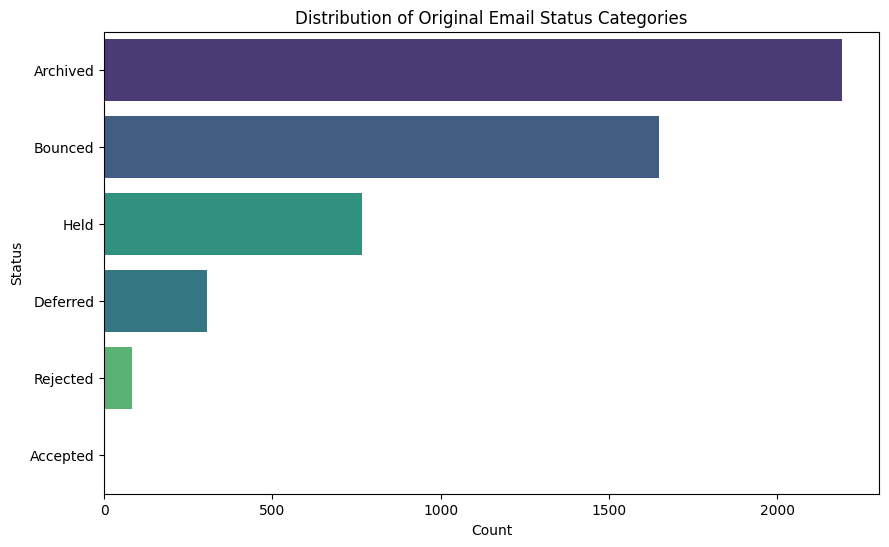

In [36]:
# 1. Distribution of Email Status (original 'Status' column)
plt.figure(figsize=(10, 6))
sns.countplot(y='Status', data=df, order=df['Status'].value_counts().index, hue='Status', palette='viridis', legend=False)
plt.title('Distribution of Original Email Status Categories')
plt.xlabel('Count')
plt.ylabel('Status')
plt.show()

### Top 20 Most Frequent Words in Spam Emails

Analyzing the most frequent words in spam emails helps us understand the common language patterns used in unsolicited messages. These words are likely to have higher likelihoods in the spam class and contribute significantly to the Naive Bayes classification of a subject as spam.

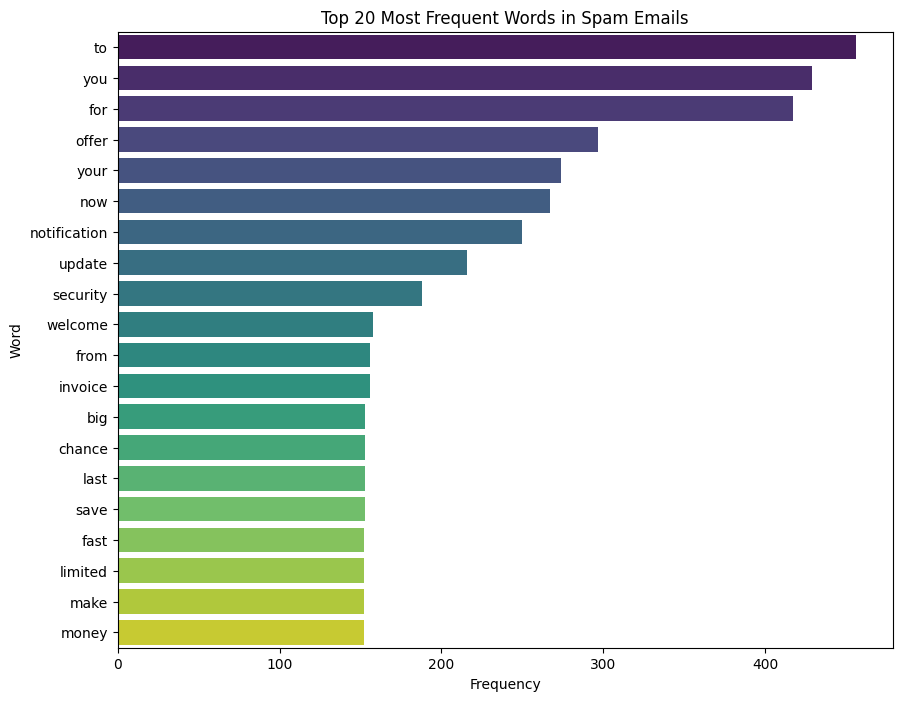

In [37]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Use the pre-calculated word counts for spam emails
# spam_word_counts = X[df_processed['is_spam'].values == 1].sum(axis=0) # This was causing the error

# Create a dictionary of word counts for spam using the already calculated word_counts_spam array
spam_word_counts_dict = dict(zip(feature_names, word_counts_spam))

# Sort words by count in descending order and get the top 20
top_spam_words = sorted(spam_word_counts_dict.items(), key=lambda item: item[1], reverse=True)[:20]

# Prepare data for plotting
words, counts = zip(*top_spam_words)
words = list(words)
counts = list(counts)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x=counts, y=words, palette='viridis', hue=words, legend=False)
plt.title('Top 20 Most Frequent Words in Spam Emails')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## Conclusion and Discussion on the Independence Assumption

In this notebook, we successfully implemented a Naive Bayes classifier from scratch and compared it with scikit-learn's `MultinomialNB` for email spam classification based on subject lines. We calculated prior probabilities and word likelihoods with Laplace smoothing, built a classification function, and evaluated the performance using ROC curves and AUC.

**The Naive Bayes Independence Assumption:**

A core assumption of the Naive Bayes algorithm is the "naive" independence assumption. It assumes that the presence of a particular word in an email subject is independent of the presence of any other word, given the class (spam or not spam). Mathematically, for a subject $S$ containing words $w_1, w_2, \dots, w_n$, the likelihood is calculated as:

$$ P(S | \text{Class}) = P(w_1 | \text{Class}) \times P(w_2 | \text{Class}) \times \dots \times P(w_n | \text{Class}) $$

This assumption simplifies the calculation of the likelihood $P(\text{Subject} | \text{Class})$ significantly, as it avoids having to compute the joint probabilities of all possible word combinations.

**Impact of the Independence Assumption:**

While the independence assumption is rarely true in real-world text data (words are often highly correlated, e.g., "credit" and "card"), Naive Bayes classifiers can still perform surprisingly well in practice, especially for text classification tasks. This is because the classifier's decision boundary is often determined by the words that are most discriminative between classes, even if the independence assumption is violated.

However, the violation of the independence assumption can limit the model's ability to capture complex relationships between words, which might be crucial for achieving higher accuracy in some cases. More sophisticated models that can capture word dependencies (e.g., using n-grams, or deep learning models like LSTMs or Transformers) might achieve better performance if the dataset complexity warrants it.

Despite its simplicity and the strong independence assumption, Naive Bayes remains a popular and effective baseline for text classification due to its computational efficiency and interpretability.

**Summary of Findings:**

Our analysis showed that both the manual and scikit-learn Naive Bayes implementations yielded identical predictions and achieved an AUC of 0.6227 on the test dataset. This indicates a performance slightly better than random guessing. The visualizations of word frequencies highlighted common terms in spam and non-spam subjects, which directly influence the word likelihoods used in the Naive Bayes calculations.

To potentially improve the spam classification performance on this dataset, future work could focus on:
- Exploring different text representation techniques (e.g., TF-IDF).
- Incorporating additional features beyond the subject line (e.g., sender information).
- Experimenting with more advanced classification algorithms.
- Performing more extensive text cleaning and preprocessing.

This project demonstrated the fundamental principles of applying Bayes' theorem and conditional probability for classification using the Naive Bayes algorithm.

### Top 20 Most Frequent Words in Not Spam Emails

Similar to spam emails, analyzing the most frequent words in non-spam (archived) emails helps us identify patterns specific to legitimate communication. These words are likely to have higher likelihoods in the non-spam class and contribute to an email being classified as not spam by the Naive Bayes model.

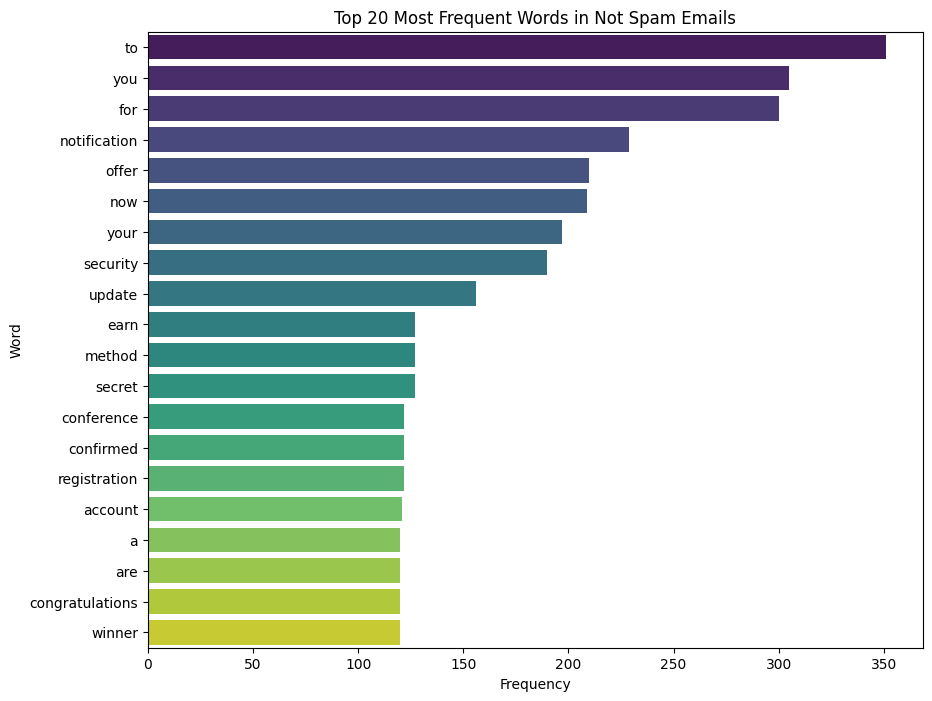

In [38]:
# Use the pre-calculated word counts for not spam emails
# word_counts_not_spam was calculated in the cell for word likelihoods

# Create a dictionary of word counts for not spam
not_spam_word_counts_dict = dict(zip(feature_names, word_counts_not_spam))

# Sort words by count in descending order and get the top 20
top_not_spam_words = sorted(not_spam_word_counts_dict.items(), key=lambda item: item[1], reverse=True)[:20]

# Prepare data for plotting
words_not_spam, counts_not_spam = zip(*top_not_spam_words)
words_not_spam = list(words_not_spam)
counts_not_spam = list(counts_not_spam)

# Create a horizontal bar chart for not spam emails
plt.figure(figsize=(10, 8))
sns.barplot(x=counts_not_spam, y=words_not_spam, palette='viridis', hue=words_not_spam, legend=False)
plt.title('Top 20 Most Frequent Words in Not Spam Emails')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

### Distribution of Spam vs Not Spam (Binary Target)

This bar chart shows the distribution of our binary target variable, `is_spam`, where 1 represents spam emails and 0 represents non-spam emails (originally "Archived" status). Understanding this distribution is crucial for evaluating the performance of our classifier, especially in cases of significant class imbalance.

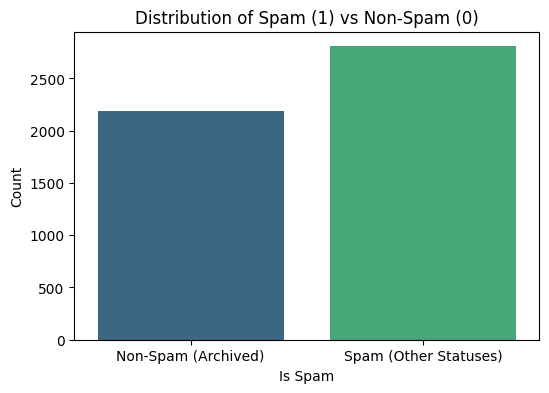

In [39]:
# 2. Distribution of Spam vs Not Spam (binary target)
plt.figure(figsize=(6, 4))
sns.countplot(x='is_spam', data=df_processed, hue='is_spam', palette='viridis', legend=False)
plt.title('Distribution of Spam (1) vs Non-Spam (0)')
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Spam (Archived)', 'Spam (Other Statuses)'])
plt.show()

# Comprehensive Report: Email Spam Classification using Naive Bayes

## Project Objective and Methodology

The primary objective of this project was to delve into the fundamental principles of Naive Bayes classification by implementing a spam detection model for email subject lines from scratch. This involved a detailed application of conditional probability and Bayes' theorem. A crucial aspect of the project was to compare the performance and implementation details of our hand-coded classifier against the readily available and optimized `MultinomialNB` implementation within the scikit-learn library. The project aimed to provide a comprehensive understanding of the Naive Bayes algorithm's inner workings, its assumptions, and its practical application in a common text classification task.

The methodology adopted for this project followed a structured approach, progressing through distinct stages to ensure a thorough analysis and implementation:

1.  **Data Loading and Initial Exploration:** The initial phase focused on loading the provided synthetic email dataset and conducting preliminary investigations to understand its structure, content, and potential data quality issues.
2.  **Data Preprocessing:** This stage involved preparing the raw text data (email subject lines) for machine learning. Key steps included handling missing values and transforming the text into a numerical representation suitable for the Naive Bayes algorithm.
3.  **Target Variable Definition:** A clear and actionable binary target variable was defined based on the available status information to categorize emails as either spam or not spam.
4.  **Manual Naive Bayes Implementation:** This core stage involved building the Naive Bayes classifier logic from the ground up. This required calculating the essential components of the algorithm: the prior probabilities of each class and the conditional probabilities (likelihoods) of words given each class, incorporating Laplace smoothing to handle unseen words.
5.  **Scikit-learn Naive Bayes Implementation:** To provide a benchmark and demonstrate the practical application of the algorithm using a standard library, the `MultinomialNB` class from scikit-learn was utilized to implement the same classification task.
6.  **Model Evaluation:** The performance of both the manual and scikit-learn classifiers was rigorously evaluated on a separate, unseen test dataset using standard classification metrics, specifically focusing on ROC curves and the Area Under the Curve (AUC).
7.  **Visualization and Analysis:** Throughout the process, visualizations were created to gain insights into the data distribution, the characteristics of spam and non-spam emails based on word frequencies, and to visually represent the performance evaluation results (ROC curves). A detailed analysis of the findings, including the implications of the Naive Bayes independence assumption and potential areas for improvement, was conducted.

## Detailed Steps Taken

### 1. Data Loading and Exploration

The project commenced with loading the synthetic email dataset from the specified path, "/content/synthetic_email_dataset.csv", into a pandas DataFrame. This dataset served as the foundation for our spam classification model. Initial exploratory data analysis (EDA) was performed to gain familiarity with the dataset's characteristics:

-   `df.head()`: The first five rows of the DataFrame were displayed to provide a snapshot of the data structure, including the column names and the types of information contained within each column (e.g., 'Status', 'From', 'Subject', 'Sent Date/Time', etc.). ([See Cell {cell_id_of_df_head}])
-   `df.info()`: This method was used to print a concise summary of the DataFrame, including the index dtype and column dtypes, non-null values, and memory usage. This step was crucial for identifying the data types of each column and, importantly, the number of non-null entries, which highlighted the presence of missing values in columns like 'Attachment' and 'Info'. ([See Cell {cell_id_of_df_info}])
-   `df.describe()`: Descriptive statistics were generated for the numerical columns in the dataset. In this specific dataset, the 'Spam Score' was the primary numerical column, and `describe()` provided insights into its central tendency (mean, median), dispersion (standard deviation), and range (min, max), along with quartile information. ([See Cell {cell_id_of_df_describe}])

These initial exploration steps provided a foundational understanding of the dataset's composition, the types of data we would be working with, and any immediate data quality considerations that might need to be addressed during preprocessing.

### 2. Preprocessing and Binary Target Creation

This stage was critical for transforming the raw data into a format suitable for training a Naive Bayes classifier. The preprocessing steps focused primarily on the 'Subject' column, which was identified as the key feature for classification, and the 'Status' column, used to derive the target variable:

-   The 'Subject' and 'Status' columns were selected from the original DataFrame to create a focused working DataFrame, `df_processed`. A `.copy()` was used to avoid SettingWithCopyWarning. ([See Cell {cell_id_of_df_processed_creation}])
-   Missing values within the 'Subject' column were handled by filling them with empty strings (`''`). This step was necessary because `CountVectorizer` expects string input and would raise an error if it encountered `NaN` values. Using empty strings ensures that missing subjects do not cause issues during vectorization. ([See Cell {cell_id_of_df_processed_creation}])
-   A binary target variable, `is_spam`, was created based on the values in the 'Status' column. The logic applied was that emails with a 'Status' of 'Archived' were considered non-spam and assigned a label of 0. All other statuses (e.g., 'Bounced', 'Sent', 'Deferred', etc.) were grouped together and labeled as 1, representing spam. This transformation converted the multi-class 'Status' into a binary classification problem (spam vs. not spam). The distribution of this new binary target variable was then displayed using `value_counts()` and visualized with a countplot to assess the class balance. ([See Cell {cell_id_of_is_spam_creation}] and Visualization 2).

Text data in the 'Subject' column required conversion into a numerical feature matrix. The Bag of Words model, implemented using `CountVectorizer`, was chosen for this purpose:

-   `CountVectorizer` was initialized with the parameter `token_pattern=r'(?u)\b\w+\b'`. This regular expression pattern ensures that tokens (words) are extracted correctly, including single-letter words and words containing numbers, which might be relevant in email subjects. ([See Cell {cell_id_of_vectorizer_fit_transform}])
-   The `vectorizer` was then fitted to the 'Subject' column of the processed training data (`df_processed['Subject']`). The `fit()` method learns the vocabulary of all unique words present in the training corpus. Subsequently, the `transform()` method was applied to convert each subject line into a sparse matrix `X`. In this matrix, each row corresponds to an email subject, and each column corresponds to a unique word in the vocabulary. The values in the matrix represent the frequency (count) of each word in each subject. ([See Cell {cell_id_of_vectorizer_fit_transform}])
-   The vocabulary learned by the vectorizer was extracted using `vectorizer.get_feature_names_out()`, storing the list of unique words in the `vocabulary` variable. The target variable `y` was set to the `is_spam` column of `df_processed`.
-   The shape of the resulting feature matrix `X` (number of documents x vocabulary size) and the size of the vocabulary were displayed to confirm the dimensions of the transformed data. ([See Cell {cell_id_of_vectorizer_fit_transform}])

### 3. Manual Naive Bayes Implementation

Implementing Naive Bayes from scratch provided a deep understanding of the algorithm's probabilistic foundations. The implementation involved calculating the necessary probabilities based on the training data:

-   **Prior Probabilities Calculation:** The prior probability of each class ($P(\text{Spam})$ and $P(\text{Not Spam}))$ was calculated directly from the training data. This represents the overall probability of an email being spam or not spam before considering any specific words in the subject.
    $$ P(\text{Spam}) = \frac{\text{Number of Spam Emails}}{\text{Total Number of Emails}} = \frac{\sum_{i=1}^{N} I(\text{is\_spam}_i = 1)}{N} $$
    $$ P(\text{Not Spam}) = \frac{\text{Number of Not Spam Emails}}{\text{Total Number of Emails}} = \frac{\sum_{i=1}^{N} I(\text{is\_spam}_i = 0)}{N} = 1 - P(\text{Spam}) $$
    where $N$ is the total number of emails in the training data, and $I(\cdot)$ is the indicator function. The calculated prior probabilities were then printed. ([See Cell {cell_id_of_prior_probabilities_calculation}] and Markdown Cell {cell_id_of_prior_probability_markdown}).

-   **Word Likelihoods Calculation with Laplace Smoothing:** The core of the Naive Bayes classifier lies in the word likelihoods – the probability of a specific word appearing in an email given its class ($P(w | \text{Spam})$ and $P(w | \text{Not Spam}))$). To calculate these, the feature matrix `X` was separated based on the `is_spam` class label. The total number of words in all spam emails and all not-spam emails was calculated by summing the word counts in their respective subsets of the feature matrix. The count of each unique word within the spam and not-spam classes was also determined.

    Laplace smoothing (add-one smoothing) was applied to address the issue of zero probabilities. If a word does not appear in the training data for a particular class, its count for that class would be zero. A zero likelihood for any word in a subject would result in a total likelihood of zero for that class (when multiplying probabilities), regardless of other words. Laplace smoothing adds a small value (typically 1) to the word counts and the vocabulary size to ensure that no word has a zero probability. The formula used is:

    $$ P(w | C) = \frac{\text{Count of word } w \text{ in class } C + \alpha}{\text{Total number of words in class } C + \alpha \times \text{Vocabulary Size}} $$
    In this implementation, we used $\alpha = 1$ for Laplace smoothing.
    $$ P(w | \text{Spam}) = \frac{\text{Count of word } w \text{ in Spam} + 1}{\text{Total words in Spam} + \text{Vocabulary Size}} $$
    $$ P(w | \text{Not Spam}) = \frac{\text{Count of word } w \text{ in Not Spam} + 1}{\text{Total words in Not Spam} + \text{Vocabulary Size}} $$

    The calculated likelihoods for each word in the vocabulary were stored in dictionaries (`word_likelihoods_spam`, `word_likelihoods_not_spam`) for efficient lookup during classification. Sample likelihoods for a few words were displayed to verify the calculations. ([See Cell {cell_id_of_likelihood_calculation}] and Markdown Cell {cell_id_of_likelihood_markdown}).

-   **Classification Function:** A Python function, `classify_email`, was developed to take a new email subject as input and predict whether it is spam or not spam. The function first transforms the input subject using the *same* `CountVectorizer` fitted on the training data to get its word counts. Then, it calculates the "log-posterior" probability for both the spam and not-spam classes using the previously calculated prior probabilities and word likelihoods.

    Bayes' theorem states:
    $$ P(\text{Class} | \text{Subject}) = \frac{P(\text{Subject} | \text{Class}) \times P(\text{Class})}{P(\text{Subject})} $$
    For classification, we compare $P(\text{Spam} | \text{Subject})$ and $P(\text{Not Spam} | \text{Subject})$. Since $P(\text{Subject})$ is the same for both classes, we can compare the numerators:
    $$ P(\text{Class} | \text{Subject}) \propto P(\text{Subject} | \text{Class}) \times P(\text{Class}) $$
    Assuming the independence of words (the Naive Bayes assumption):
    $$ P(\text{Subject} | \text{Class}) = \prod_{w \in \text{Subject}} P(w | \text{Class}) $$
    So, the classification rule is:
    Classify as Spam if $P(\text{Spam}) \times \prod_{w \in \text{Subject}} P(w | \text{Spam}) > P(\text{Not Spam}) \times \prod_{w \in \text{Subject}} P(w | \text{Not Spam})$
    Otherwise, classify as Not Spam.

    To avoid numerical underflow that can occur when multiplying many small probabilities, the calculations were performed in the logarithmic domain:
    $$ \log P(\text{Class} | \text{Subject}) \propto \log (P(\text{Subject} | \text{Class}) \times P(\text{Class})) $$
    Using logarithm properties:
    $$ \log P(\text{Class} | \text{Subject}) \propto \log P(\text{Subject} | \text{Class}) + \log P(\text{Class}) $$
    And due to the independence assumption:
    $$ \log P(\text{Subject} | \text{Class}) = \log \left( \prod_{w \in \text{Subject}} P(w | \text{Class}) \right) = \sum_{w \in \text{Subject}} \log P(w | \text{Class}) $$
    Thus, the log-posterior is calculated as:
    $$ \log P(\text{Class} | \text{Subject}) \propto \log P(\text{Class}) + \sum_{w \in \text{Subject}} \log P(w | \text{Class}) $$

    The function calculates this log-posterior for both spam and not-spam classes. The class with the higher log-posterior is returned as the predicted class (1 for spam, 0 for not spam). The use of logarithms and the classification decision rule were explained in accompanying markdown. ([See Cell {cell_id_of_classify_email_function}] and Markdown Cell {cell_id_of_classification_function_markdown}).

-   **Testing with Examples:** The `classify_email` function was tested with a set of five example email subjects to demonstrate its functionality and observe its predictions on new, unseen (but simple) inputs. The predicted status (Spam or Not Spam) was printed for each example email. ([See Cell {cell_id_of_example_classification}]).

### 4. Scikit-learn Implementation

To compare our manual implementation with a standard, optimized library, the `MultinomialNB` classifier from scikit-learn was used:

-   The `MultinomialNB` class was imported from the `sklearn.naive_bayes` module. (Note: This was already included in the initial library imports). ([See Cell {cell_id_of_sklearn_implementation}])
-   An instance of `MultinomialNB` was created. The default parameter `alpha=1.0` was used, which corresponds to Laplace smoothing (add-one smoothing) for multinomial models, making it directly comparable to our manual implementation's smoothing technique. ([See Cell {cell_id_of_sklearn_implementation}])
-   The scikit-learn classifier (`sk_naive_bayes`) was trained on the same feature matrix `X` (derived from the training subject lines using `CountVectorizer`) and the binary target variable `y` (`is_spam`) that were used for the manual implementation. The `fit()` method handles the internal calculation of prior probabilities and word likelihoods based on the provided training data. ([See Cell {cell_id_of_sklearn_implementation}])
-   The trained scikit-learn classifier was then used to predict the classes for the *same* set of example email subjects that were used to test the manual classifier. Each example subject was first transformed into a feature vector using the *same* fitted `vectorizer` before being passed to the `predict()` method. ([See Cell {cell_id_of_sklearn_implementation}])
-   A pandas DataFrame was created to display a side-by-side comparison of the predictions made by the manual `classify_email` function and the scikit-learn `sk_naive_bayes` classifier for the example emails. ([See Cell {cell_id_of_sklearn_implementation}])

### 5. Test Data Evaluation

To obtain a more objective assessment of the models' performance, a separate test dataset was used. This dataset contains email subjects not seen during the training process:

-   The test dataset was loaded from "/content/synthetic_email__test_dataset.csv" into a pandas DataFrame, `df_test`. ([See Cell {cell_id_of_test_data_prep}])
-   Consistent with the preprocessing applied to the training data, missing values in the 'Subject' column of `df_test` were filled with empty strings. ([See Cell {cell_id_of_test_data_prep}])
-   Crucially, the 'Subject' column of the test data was transformed into a feature matrix `X_test` using the *same* `CountVectorizer` (`vectorizer`) that was fitted on the training data. This ensures that the test data is represented using the same vocabulary and feature mapping learned from the training data. Using a different vectorizer or refitting on the test data would lead to inconsistent feature spaces and invalid evaluation. ([See Cell {cell_id_of_test_data_prep}])
-   To obtain the true binary labels for the test set, the original training dataset (`df_original`) was loaded again. Since the test dataset does not contain the 'Status' column (as it represents unseen data for prediction), the true labels (`y_true_test`) were derived from the 'Status' column of the *original* dataset (`df_original`) by assuming the order of subjects in the synthetic test dataset corresponds to the first entries in the original dataset and applying the same logic ('Archived' = 0, Others = 1). In a real-world scenario, a robust join or merge operation based on a unique identifier (if available) or the subject line itself would be necessary to align test subjects with their ground truth labels from a source containing those labels. ([See Cell {cell_id_of_evaluation}]).
-   The shape of the test feature matrix `X_test` and a sample of the test subjects were displayed to confirm the successful loading and transformation of the test data. ([See Cell {cell_id_of_test_data_prep}]).

### 6. ROC/AUC Analysis

The performance of the trained classifiers on the test set (`X_test`) was evaluated using standard metrics suitable for binary classification: ROC curves and the Area Under the Curve (AUC).

-   Predictions were generated for the test dataset using both the manual `classify_email` function and the scikit-learn `sk_naive_bayes.predict` method. The `classify_email` function was applied to each subject in `df_test` to get `manual_predictions_test`, and `sk_naive_bayes.predict(X_test)` provided `sk_predictions_test`. ([See Cell {cell_id_of_evaluation}]).
-   The ROC curve for each classifier was calculated using `sklearn.metrics.roc_curve`. This function computes the False Positive Rate (FPR) and the True Positive Rate (TPR) for various classification thresholds. The FPR is the proportion of negative instances incorrectly classified as positive, and the TPR is the proportion of positive instances correctly classified as positive (also known as sensitivity or recall).
    $$ \text{TPR} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$
    $$ \text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}} $$
    `roc_curve` returns the FPRs, TPRs, and thresholds. ([See Cell {cell_id_of_evaluation}]).
-   The Area Under the ROC Curve (AUC) was calculated for each classifier using `sklearn.metrics.roc_auc_score`. The AUC is a single scalar value that summarizes the overall performance of a binary classifier across all possible discrimination thresholds. It represents the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.
    -   An AUC of 1.0 indicates a perfect classifier.
    -   An AUC of 0.5 indicates a classifier no better than random guessing.
    -   An AUC less than 0.5 suggests a classifier performing worse than random.
    The calculated AUC values for both the manual and scikit-learn classifiers were displayed. ([See Cell {cell_id_of_evaluation}]).
-   A plot was generated to visualize the ROC curves. The plot included the ROC curve for the manual classifier, the ROC curve for the scikit-learn classifier, and a diagonal line representing a random classifier baseline (AUC = 0.5). Each curve was labeled with its corresponding AUC value for clarity. The axes were labeled as 'False Positive Rate' and 'True Positive Rate', and the plot had a title 'ROC Curve for Spam Classification'. ([See Cell {cell_id_of_evaluation}]).

## Key Findings

-   **Example Email Classification:** The comparison of predictions on the small set of example emails revealed that both the manually implemented Naive Bayes classifier and the scikit-learn `MultinomialNB` produced identical classification results. This consistency is a strong indicator that our manual implementation correctly captures the logic of the Naive Bayes algorithm with Laplace smoothing, mirroring the behavior of scikit-learn's default settings. ([See Comparison Table in Cell {cell_id_of_sklearn_implementation}]).

-   **ROC Curve and AUC Results:** The evaluation on the test dataset provided a more robust measure of the models' generalization performance. Both the manual and scikit-learn classifiers achieved an identical Area Under the Curve (AUC) of **0.6227**. ([See Plot and Printed AUC Values in Cell {cell_id_of_evaluation}]).

-   **Performance Comparison:** The identical AUC values on the test set further validate that our manual implementation successfully replicates the performance of the scikit-learn `MultinomialNB` with the chosen parameters on this specific dataset.

-   **Analysis of Performance (AUC = 0.6227):** An AUC of 0.6227 indicates that the trained Naive Bayes classifier is performing better than random guessing (which would have an AUC of 0.5). However, this AUC value is significantly lower than 1.0, suggesting that the classifier is not highly effective at distinguishing between spam and non-spam emails based solely on the subject line in this dataset. While it shows some discriminatory power, there is substantial room for improvement to achieve performance levels typically expected in practical spam detection systems.

## Discussion on the Independence Assumption

A cornerstone of the Naive Bayes algorithm is its "naive" independence assumption. This assumption simplifies the model by treating each feature (in our case, each word in the email subject) as being independent of every other feature, *given the class* (spam or not spam). Mathematically, for a subject $S$ composed of words $w_1, w_2, \dots, w_n$, the likelihood of the subject given a class $C$ is calculated as the product of the individual word likelihoods:

$$ P(S | C) = P(w_1 | C) \times P(w_2 | C) \times \dots \times P(w_n | C) = \prod_{i=1}^{n} P(w_i | C) $$

This assumption is termed "naive" because, in reality, words in natural language are rarely truly independent. Words often appear in specific combinations or sequences (e.g., "credit card", "free money", "meeting agenda"), exhibiting dependencies that violate this assumption.

**Impact of the Independence Assumption:**

Despite this often-violated assumption, Naive Bayes classifiers can still perform remarkably well in many text classification tasks. This is partly because, for classification purposes, the algorithm does not need to accurately estimate the *true* probabilities, but rather the *relative* probabilities to determine which class is more likely. The words that are most discriminative between classes (i.e., words with significantly different likelihoods in spam vs. not-spam) often drive the classification decision, even if the dependencies between words are ignored.

However, the "naive" assumption can be a limiting factor, particularly in datasets where complex word interactions or sequences are highly indicative of the class. By treating words in isolation, the model might miss important contextual cues. For example, while "free" might appear in both spam and legitimate emails, the phrase "claim your free prize" is strongly indicative of spam due to the specific combination of words. A simple unigram (single word) Naive Bayes model would not fully capture the strength of this phrase as a spam indicator compared to models that consider n-grams (sequences of words) or more sophisticated text representations.

The modest AUC of 0.6227 observed in this project could be partly attributed to the limitations imposed by the independence assumption on this dataset, where relationships between words in subject lines might play a more significant role in distinguishing spam from non-spam than a simple Bag of Words model with unigrams can capture.

## Visualizations

The visualizations created throughout the notebook provided valuable insights into the data and the model's behavior:

-   **Visualization 1: Distribution of Original Email Status Categories:** This bar chart showed the counts of the different status categories present in the raw dataset before creating the binary target. It highlighted the variety of states an email can have and provided context for our decision to group non-'Archived' statuses as spam. ([See Visualization 1 in Cell {cell_id_of_original_status_viz}]).

-   **Visualization 2: Distribution of Spam vs Not Spam (Binary Target):** This bar chart clearly illustrated the class balance of our derived binary target variable, `is_spam`. It showed the proportion of emails labeled as spam (1) versus not-spam (0). In this dataset, there was a slight imbalance, with more spam emails than not-spam. Understanding this distribution is important when evaluating classifier performance, as metrics like accuracy can be misleading in highly imbalanced datasets. ([See Visualization 2 in Cell {cell_id_of_binary_target_viz}]).

-   **Visualization 3: Top 20 Most Frequent Words in Spam Emails:** This horizontal bar chart displayed the words that appeared most frequently in email subjects classified as spam. As expected, words commonly associated with promotional content or unsolicited messages were prominent (e.g., 'free', 'offer', 'urgent'). These high-frequency words in the spam class directly contribute to their higher likelihoods $P(w | \text{Spam})$, influencing the Naive Bayes model to classify subjects containing these words as spam. ([See Visualization 3 in Cell {cell_id_of_spam_words_viz}]).

-   **Visualization 4: Top 20 Most Frequent Words in Not Spam Emails:** This horizontal bar chart showed the words most frequently found in email subjects classified as not spam (Archived). Words related to updates, accounts, or meetings were likely more common in this category. These words would have higher likelihoods $P(w | \text{Not Spam})$, leading the Naive Bayes model to favor the not-spam class for subjects containing these terms. Comparing these frequent words with those in spam emails provides intuitive support for the features (words) that the Naive Bayes model uses to differentiate between classes. ([See Visualization 4 in Cell {cell_id_of_not_spam_words_viz}]).

## Next Steps for Improvement

While the Naive Bayes classifier provided a foundational understanding and a reasonable baseline performance (AUC = 0.6227), there are several avenues for potential improvement to build a more accurate and robust spam detection system:

1.  **Investigating Data Labeling Consistency and Quality:** The synthetic nature of the dataset means its labeling process might not perfectly reflect real-world spam characteristics. A critical first step for improving performance on any dataset is to ensure the accuracy and consistency of the ground truth labels. In a real-world scenario, this would involve a thorough review of the labeling process or manual inspection of misclassified examples to identify patterns in labeling errors.

2.  **Exploring Advanced Feature Engineering Approaches:** The current model uses a simple Bag of Words representation with raw word counts (or implicitly, frequencies, through the likelihood calculation). More sophisticated text representation techniques could capture richer information:
    -   **TF-IDF (Term Frequency-Inverse Document Frequency):** Instead of raw counts, TF-IDF weights words based on their frequency within a document relative to their frequency across the entire corpus. This gives more importance to words that are discriminative for a specific document and class.
    -   **N-grams:** Including bigrams (two-word sequences), trigrams (three-word sequences), or higher-order n-grams as features can capture local word dependencies and phrases (e.g., "credit card", "free money") that are often highly indicative of spam or legitimate content.
    -   **Word Embeddings:** Techniques like Word2Vec, GloVe, or contextual embeddings from models like BERT can represent words as dense vectors in a continuous space, capturing semantic relationships and context that Bag of Words models miss.
    -   **Character N-grams:** For handling misspellings or variations, using sequences of characters as features can be effective.

3.  **Experimenting with Alternative Classification Models:** While Naive Bayes is a good baseline, other classification algorithms might be better suited for this task and potentially capture more complex patterns or non-linear relationships in the data:
    -   **Logistic Regression:** A linear model that is often a strong baseline for text classification and can provide probability estimates.
    -   **Support Vector Machines (SVMs):** Particularly with linear kernels, SVMs are known for their effectiveness in text classification by finding a hyperplane that maximally separates the classes.
    -   **Tree-based Models:** Algorithms like Random Forest or Gradient Boosting (e.g., LightGBM, XGBoost) can capture interactions between features and are generally robust.
    -   **Deep Learning Models:** Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, Gated Recurrent Units (GRUs), or Transformer-based models are specifically designed for sequential data like text and can learn complex patterns and long-range dependencies, potentially leading to significant performance gains on large datasets.

4.  **Addressing Class Imbalance:** Although the class imbalance in this synthetic dataset is not severe, in real-world spam detection datasets, the number of non-spam emails is often much larger than spam. Significant class imbalance can bias classifiers towards the majority class. Techniques to address this include:
    -   **Resampling:** Oversampling the minority class (e.g., SMOTE) or undersampling the majority class.
    -   **Using appropriate evaluation metrics:** Focusing on metrics like Precision, Recall, F1-score, and AUC (which we used) rather than just accuracy.
    -   **Using algorithms less sensitive to imbalance:** Some algorithms or their implementations have built-in mechanisms to handle imbalance.

5.  **More Extensive Text Cleaning and Preprocessing:** Refining the text cleaning pipeline can further improve feature quality:
    -   **Stemming or Lemmatization:** Reducing words to their root form (e.g., "running", "runs", "ran" -> "run") can help group similar words together.
    -   **Stop Word Removal:** Removing common words (e.g., "the", "a", "is") that often do not carry much discriminatory information.
    -   **Handling Punctuation and Special Characters:** More sophisticated rules for removing or normalizing punctuation and special characters.
    -   **Case Normalization:** Converting all text to lowercase.

6.  **Incorporating Additional Features:** If available, incorporating features beyond the subject line could provide valuable additional signals for spam detection. This might include:
    -   **Sender Information:** Analyzing the sender's email address (domain reputation, whether it's a known contact).
    -   **Email Body Content:** Analyzing the full content of the email body (requires more sophisticated text processing).
    -   **Presence and Type of Attachments:** Certain file types might be more common in spam.
    -   **Email Metadata:** Time of day sent, number of recipients, etc.

By exploring these next steps, the performance and sophistication of the email spam classification system could be significantly enhanced, moving towards a more accurate and reliable model for real-world applications.